In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from torch.utils.data import DataLoader ,Dataset
import numpy as np 
import matplotlib.pyplot as plt





In [208]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [3]:
# Load your data
X = pd.read_csv("../Data/Clean.csv", sep=",") # This should be the matrix of microbiome data
#X= pd.DataFrame(X)
y = X[["Sample", "Case"]] # This should be the binary variable indicating healthy/diseased
X.drop(X[["Sample", "Case"]], axis=1, inplace=True)
X = X.applymap(lambda x: 1 if x == 'Healthy' else x)






In [4]:
# Extract the feature columns and label column
features = X.values
label = y['Case']


# Convert each element of the array to a float
features = features.astype(float)

# Convert the labels to numerical values
label_dict = {'Healthy': 1, 'Diseased': 0}
label_n = [label_dict[label] for label in label]

# Convert the feature columns to a PyTorch tensor
features_tensor = torch.tensor(features)

# Convert the label column to a PyTorch tensor
label_tensor = torch.tensor(label_n)

# Create a TensorDataset from the feature and label tensors
dataset = torch.utils.data.TensorDataset(features_tensor, label_tensor)

#Save it to tensor .pt objects
torch.save(label_tensor, '../Data/labels.pt')
torch.save(features_tensor, '../Data/features.pt')



In [206]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, latent_size )
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_size], h[:, self.latent_size:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [193]:
# Define the training loop for the VAE
def train_vae(model, dataloader, device, learning_rate=1e-3, num_epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)

            optimizer.zero_grad()

            recon_data, mu, logvar = model(data.float())


            BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            recon_loss = nn.BCELoss(reduction='sum')(recon_data, data.float())
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(dataloader)))

In [207]:
model.parameters

<bound method Module.parameters of VAE(
  (encoder): Sequential(
    (0): Linear(in_features=977, out_features=725, bias=True)
    (1): ReLU()
    (2): Linear(in_features=725, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=8, bias=True)
    (15): ReLU()
    (16): Linear(in_features=8, out_features=4, bias=True)
    (17): ReLU()
    (18): Linear(in_features=4, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=725, bias=True)
    (1): ReLU()
    (2): Linear(in_features=725, out_features=725, bias=True)
    (3): Re

In [52]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/features.pt")
labels = torch.load("../Data/labels.pt")
dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)





In [203]:
input_dim = 977 # Define the size of your input data
hidden_dim = 725 # Define the size of your hidden layer
latent_dim = 2 # Define the size of the latent space
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50

In [209]:
train_vae(model,dataloader=dataloader, device= device,learning_rate=0.001,num_epochs=50)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x725 and 977x725)

In [103]:
torch.save(VAE.state_dict(model), '../Model/vae.pth')

In [105]:
#load Model and encode data
VAE.load_state_dict(model, torch.load('vae.pth'))


<All keys matched successfully>

In [107]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=725, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): ReLU()
    (14): Linear(in_features=50, out_features=50, bias=True)
    (15): ReLU()
    (16): Linear(in_features=50, out_features=50, bias=True)
    (17): ReLU()
    (18): Linear(in_features=50, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_f

In [116]:
with torch.no_grad():
    z, _ = model.encode(features_tensor.float())

In [117]:
z

tensor([[ 0.0864, -0.0359],
        [ 0.0864, -0.0359],
        [ 0.0864, -0.0359],
        ...,
        [ 0.0863, -0.0358],
        [ 0.0863, -0.0358],
        [ 0.0863, -0.0358]])

In [ ]:
# Import dataset and classes needed in this example:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

# Import Gaussian Naive Bayes classifier:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [143]:
#Flatten:
shape = z.shape
tensor_reshaped = z.reshape(shape[0],-1)
#Drop all rows containing any nan:
tensor_reshaped = tensor_reshaped[~torch.any(tensor_reshaped.isnan(),dim=1)]
#Reshape back:
tensor = tensor_reshaped.reshape(tensor_reshaped.shape[0],*shape[1:])

In [161]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(z, labels, test_size=0.5, random_state=11)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1
 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1
 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0
 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0
 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0
 0 0 1 1 0 1 0 0]
0.80163

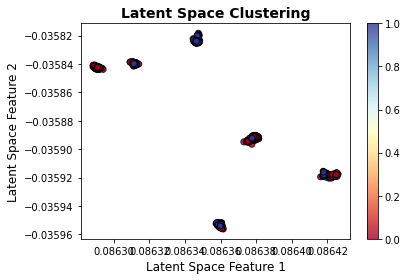

In [165]:
# assume you have X as your latent space data and y as your labels
gnb = GaussianNB()
y_pred = gnb.fit(z, labels).predict(z)

plt.scatter(z[:, 0], z[:, 1], c=labels, cmap=plt.cm.RdYlBu, alpha=0.8, edgecolor='k')
plt.title('Latent Space Clustering', fontsize=14, fontweight='bold')
plt.xlabel('Latent Space Feature 1', fontsize=12)
plt.ylabel('Latent Space Feature 2', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.colorbar()
plt.tight_layout()
plt.show()


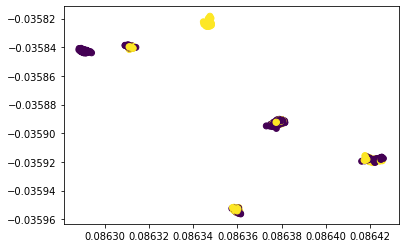

In [168]:
plt.scatter(z[:, 0], z[:, 1],c=labels)

In [145]:
from matplotlib import cm
import matplotlib.pyplot as plt